In [1]:
%load_ext autoreload
%autoreload 2

# 1. Load Library

In [2]:
import os
import pickle
import paxplot as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(f'Current working directory: {os.getcwd()}')
os.chdir('../')
print(f'New working directory: {os.getcwd()}')

Current working directory: /Users/gbemidebe/Documents/GitHub/ImputeNet/notebooks
New working directory: /Users/gbemidebe/Documents/GitHub/ImputeNet


In [3]:
from cdi.plotters import Plotters
plotter = Plotters()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# 2. Load Data

In [4]:
desired_columns = ['SA', 'DG', '%N', '%O', '%S', 'CD', 'CONC', 'CAP']
data = pd.read_csv('data/specific_capacitance_data.csv')
data = data[desired_columns]
data.head()

,SA,DG,%N,%O,%S,CD,CONC,CAP
0,1122.5,0.85,NaN,5.7,NaN,0.5,6.0,240.63
1,1122.5,0.85,NaN,5.7,NaN,1.0,6.0,228.13
2,1122.5,0.85,NaN,5.7,NaN,2.0,6.0,225.00
3,1122.5,0.85,NaN,5.7,NaN,5.0,6.0,215.63
4,1122.5,0.85,NaN,5.7,NaN,10.0,6.0,206.25


In [5]:
data.describe().transpose() # different count because of missing values

,count,mean,std,min,25%,50%,75%,max
SA,620.0,580.417565,575.592360,37.90,196.8000,350.90,710.0000,2276.60
DG,541.0,1.135749,0.329656,0.38,0.9800,1.05,1.2800,2.57
%N,402.0,4.018955,2.985963,0.00,1.5200,2.97,5.8825,13.40
%O,542.0,12.289668,6.494863,2.36,7.2725,11.20,15.4500,35.15
%S,236.0,2.258559,3.926362,0.10,0.7000,1.20,2.3900,26.56
CD,620.0,6.249113,9.181171,0.10,1.0000,3.00,10.0000,100.00
CONC,620.0,5.167742,1.868692,0.25,6.0000,6.00,6.0000,6.00
CAP,620.0,204.744435,81.513203,25.00,150.0000,200.00,253.4000,566.00


# 3. Determine threshold

In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from cdi.optimizer import get_threshold
from cdi.plotters import plot_elbow
from cdi.dataPreprocessing import Imputation

In [7]:
method = 'ExtraTreesRegressor'
model = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=20),
                                 random_state=0,
                                 max_iter=200)

IMPUTER = Imputation(data=data, columns=desired_columns, model=model, method=method)

df_imputed = IMPUTER.impute_data(split_data=False)


2024-05-12 20:40:32.174 | INFO     | cdi.dataPreprocessing:impute:100 - Database path:        SA    DG  %N   %O  %S    CD  CONC     CAP
0  1122.5  0.85 NaN  5.7 NaN   0.5   6.0  240.63
1  1122.5  0.85 NaN  5.7 NaN   1.0   6.0  228.13
2  1122.5  0.85 NaN  5.7 NaN   2.0   6.0  225.00
3  1122.5  0.85 NaN  5.7 NaN   5.0   6.0  215.63
4  1122.5  0.85 NaN  5.7 NaN  10.0   6.0  206.25
2024-05-12 20:40:32.174 | INFO     | cdi.dataPreprocessing:impute:101 - ML method: ExtraTreesRegressor

2024-05-12 20:40:32.175 | INFO     | cdi.dataPreprocessing:impute:103 - Number of data points: 620
2024-05-12 20:40:32.175 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "SA": 0
2024-05-12 20:40:32.176 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "DG": 79
2024-05-12 20:40:32.176 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing values in "%N": 218
2024-05-12 20:40:32.177 | WARNING  | cdi.dataPreprocessing:impute:106 - Number of missing

In [8]:
# get the feature space
training_data = df_imputed.iloc[:, :-1]
training_data.head()

,SA,DG,%N,%O,%S,CD,CONC
0,1122.5,0.85,3.9640,5.7,1.6685,0.5,6.0
1,1122.5,0.85,3.7920,5.7,1.4455,1.0,6.0
2,1122.5,0.85,3.7920,5.7,1.4455,2.0,6.0
3,1122.5,0.85,3.9385,5.7,1.8195,5.0,6.0
4,1122.5,0.85,3.8750,5.7,1.7555,10.0,6.0


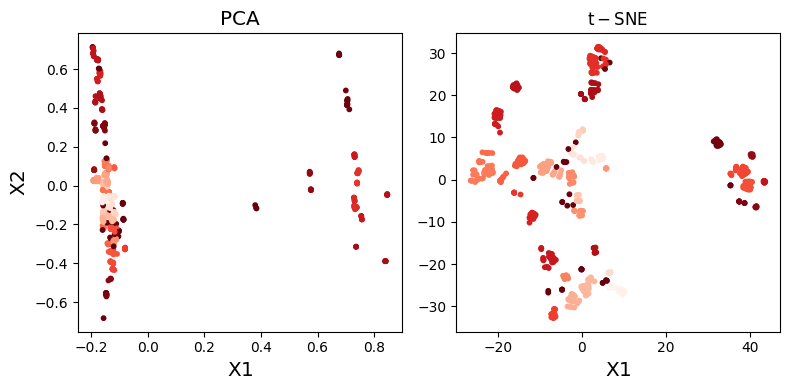

In [9]:
plotter.plot_design_space(training_data)

In [10]:
# check the threshold for different n_neighbors
record_threshold = {}
for n_neigh in [2, 3, 5, 10, 20, 30, 40, 50]:
    threshold, nbrs, distances = get_threshold(plot=plot_elbow, n_neighbors=n_neigh, training_data=training_data.values, show_fig=False)
    record_threshold[n_neigh] = threshold
    print(f'n_neighbor: {n_neigh}, threshold: {threshold}, max_distance: {max(distances)}')

n_neighbor: 2, threshold: 42.06787891313276, max_distance: 50.00000272249992
n_neighbor: 3, threshold: 42.09461291246185, max_distance: 69.16927616362626
n_neighbor: 5, threshold: 70.4092967458843, max_distance: 85.3993344895029
n_neighbor: 10, threshold: 95.04280772499305, max_distance: 123.13361271399447
n_neighbor: 20, threshold: 213.52862485917424, max_distance: 272.3359752529951
n_neighbor: 30, threshold: 341.99651062583945, max_distance: 357.661334377928
n_neighbor: 40, threshold: 357.83345701631924, max_distance: 411.0003086887526
n_neighbor: 50, threshold: 452.00026975130226, max_distance: 486.539690189043


Text(0, 0.5, '$\\rm threshold$')

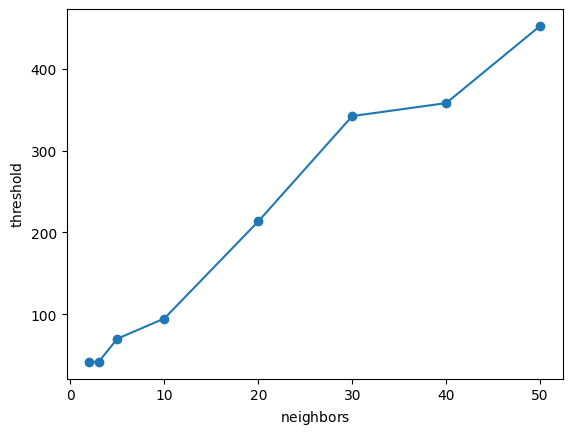

In [11]:
# plot the threshold against n_neighbors
plt.plot(list(record_threshold.keys()), list(record_threshold.values()), 'o-')
plt.xlabel(r'$\rm neighbors$')
plt.ylabel(r'$\rm threshold$')

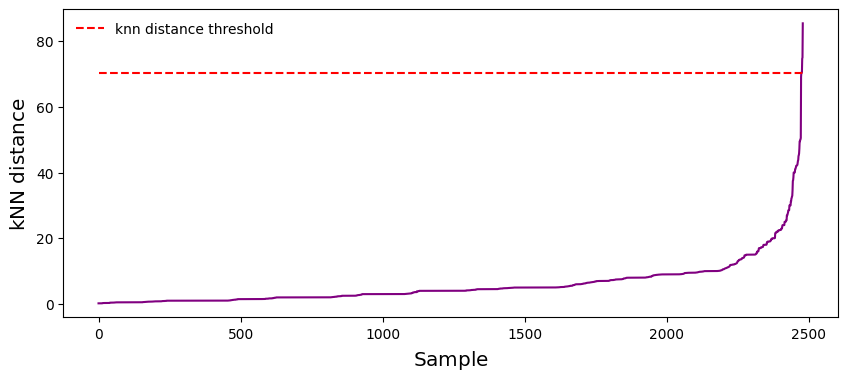

Threshold: 70.4092967458843, Max KNN distance from 5 neigbhors: 85.3993344895029


In [12]:
selected_neighbor = 5
threshold, nbrs, distances = get_threshold(plot=plot_elbow, training_data=training_data.values, n_neighbors=selected_neighbor, show_fig=True)

print(f"Threshold: {threshold}, Max KNN distance from {selected_neighbor} neigbhors: {max(distances)}")

# ML model

In [13]:
from cdi.model import specific_capacitance_ML

In [14]:
# Restore the weights
reloaded_TargetModel = specific_capacitance_ML()
reloaded_TargetModel.load_weights('./models/specific_capacitance_target_model_ETR_imputation_approach.h5')
reloaded_TargetModel.get_weights()

[array([[-0.20077813,  0.8350732 ,  0.7231782 , -0.23601975, -0.07467222,
          0.43934092,  0.20523462, -0.15256754, -0.7161128 ,  0.28352514,
         -0.3529283 , -0.19069862, -1.5971189 , -1.2791731 , -0.2813979 ,
         -0.07092988, -0.06268024,  1.0283135 , -0.24857229,  1.2012216 ,
         -0.73447454],
        [ 1.4428788 , -0.13848816,  0.37310895, -0.54613334, -0.3847814 ,
         -0.48956025, -0.47381696,  0.5570575 , -0.17035139, -0.63503367,
          0.01308822,  0.1797487 ,  0.57102054, -1.196856  ,  0.03482786,
          1.4042886 , -0.4524534 , -0.6797425 , -0.02529435, -0.33289906,
          0.46815297],
        [-0.18881309,  0.7883478 , -1.6548938 , -0.48061833, -0.37875152,
         -0.00922541, -1.7637225 ,  1.2287381 , -0.52045465,  0.6782233 ,
          0.47552058, -0.5237494 ,  0.48737392,  1.1301984 , -0.18813226,
         -0.05076721, -0.16052687,  0.7209138 , -0.33722067,  0.19757801,
         -0.0932346 ],
        [-0.58497685, -0.5736477 , -0.60245

# 5. Optimization

In [15]:
# custom functions
from cdi.optimizer import specific_capacitance
from cdi.plotters import plot_multi_ga_case_D2, plot_elbow
from cdi.model import obj_func
# pymoo
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.lhs import LHS

In [16]:
# load scaler
scaler_name =  '2024-02-04_actual_specific_capacitance_scaler_seed612_train_size70.0percent'
scaler = pickle.load(open(f'./models/{scaler_name}.pkl', 'rb'))

In [17]:
x = [0.1, 10, 20, 30, 40, 50, 60]
print(len(x))
x_df = pd.DataFrame([x], columns=training_data.columns)
obj_func(model=reloaded_TargetModel, scaler=scaler, X=x_df)

7
1/1 [==============================] - 0s 67ms/step


array([4576.952], dtype=float32)

In [18]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SA,620.0,580.417565,575.592360,37.90,196.8000,350.90,710.0000,2276.60
DG,541.0,1.135749,0.329656,0.38,0.9800,1.05,1.2800,2.57
%N,402.0,4.018955,2.985963,0.00,1.5200,2.97,5.8825,13.40
%O,542.0,12.289668,6.494863,2.36,7.2725,11.20,15.4500,35.15
%S,236.0,2.258559,3.926362,0.10,0.7000,1.20,2.3900,26.56
CD,620.0,6.249113,9.181171,0.10,1.0000,3.00,10.0000,100.00
CONC,620.0,5.167742,1.868692,0.25,6.0000,6.00,6.0000,6.00
CAP,620.0,204.744435,81.513203,25.00,150.0000,200.00,253.4000,566.00


5/5 [==============================] - 0s 3ms/step


Text(0, 0.5, 'Actual CAP')

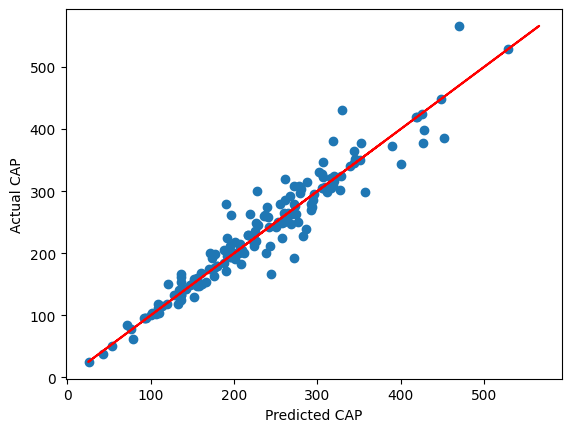

In [19]:
plt.scatter(obj_func(model=reloaded_TargetModel, scaler=scaler, X=data.dropna().iloc[:, :-1]), data.dropna()['CAP'])
plt.plot(data.dropna()['CAP'], data.dropna()['CAP'], color='r')

plt.xlabel('Predicted CAP')
plt.ylabel('Actual CAP')

In [20]:
problem = specific_capacitance(training_data=training_data, nbrs=nbrs, threshold=threshold,
                                obj_func=obj_func, model=reloaded_TargetModel, scaler=scaler)
sampling = LHS()
algorithm = NSGA2(pop_size=100)
result = minimize(problem, algorithm, ('n_gen', 200), 
                  seed=1, save_history=True, verbose=False)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

1/1 [==============================] - 0s 8ms/step


In [21]:
# ML output of the GA
np.asarray(-result.F[:, 0]).reshape(-1,)

array([6593.98974609, 3336.53491211, 6552.47802734, 6488.93164062,
       6291.16650391, 6343.42236328, 3591.44458008, 6590.99169922,
       6488.14306641, 6487.90136719, 3716.16625977, 5637.84423828,
       4158.46289062, 4533.66699219, 5693.72900391, 5004.50292969,
       6488.52441406, 6392.77441406, 4616.09277344, 5054.96044922,
       4746.65478516, 6383.52050781, 6488.84521484, 5879.27490234,
       5987.47265625, 6441.24316406, 6425.63378906, 3808.81518555,
       4844.44775391, 5473.45410156, 6592.56689453, 3872.82666016,
       5606.93994141, 3980.94360352, 5530.81445312, 5939.56591797,
       4222.17285156, 5823.34082031, 5315.55371094, 4696.46679688,
       4397.32519531, 4963.9375    , 6477.73144531, 4439.42871094,
       3927.49487305, 5364.38623047, 5780.31152344, 4068.77514648,
       5731.27636719, 6177.49609375, 6200.72119141, 5237.68359375,
       3755.39135742, 3370.40893555, 6593.60009766, 5756.89208984,
       5577.65527344, 6018.81982422, 4883.28466797, 5331.68359

In [22]:
# KNN distance of the GA
np.asarray(result.F[:, 0]).reshape(-1,)

array([-6593.98974609, -3336.53491211, -6552.47802734, -6488.93164062,
       -6291.16650391, -6343.42236328, -3591.44458008, -6590.99169922,
       -6488.14306641, -6487.90136719, -3716.16625977, -5637.84423828,
       -4158.46289062, -4533.66699219, -5693.72900391, -5004.50292969,
       -6488.52441406, -6392.77441406, -4616.09277344, -5054.96044922,
       -4746.65478516, -6383.52050781, -6488.84521484, -5879.27490234,
       -5987.47265625, -6441.24316406, -6425.63378906, -3808.81518555,
       -4844.44775391, -5473.45410156, -6592.56689453, -3872.82666016,
       -5606.93994141, -3980.94360352, -5530.81445312, -5939.56591797,
       -4222.17285156, -5823.34082031, -5315.55371094, -4696.46679688,
       -4397.32519531, -4963.9375    , -6477.73144531, -4439.42871094,
       -3927.49487305, -5364.38623047, -5780.31152344, -4068.77514648,
       -5731.27636719, -6177.49609375, -6200.72119141, -5237.68359375,
       -3755.39135742, -3370.40893555, -6593.60009766, -5756.89208984,
      

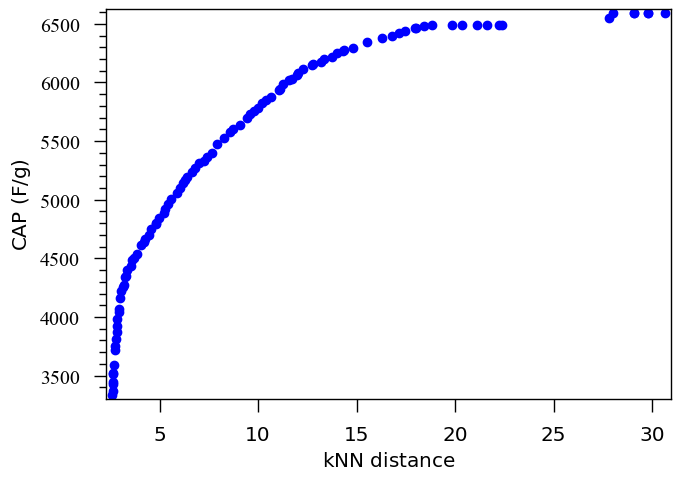

In [23]:
plotter.plot_pareto(
    obj1 = result.F[:, 1], # KNN distance
                    obj2 = -1*result.F[:, 0], # Specific capacitance
                    ylabel = r'$\rm CAP\ (F/g)$',
                    threshold = threshold)

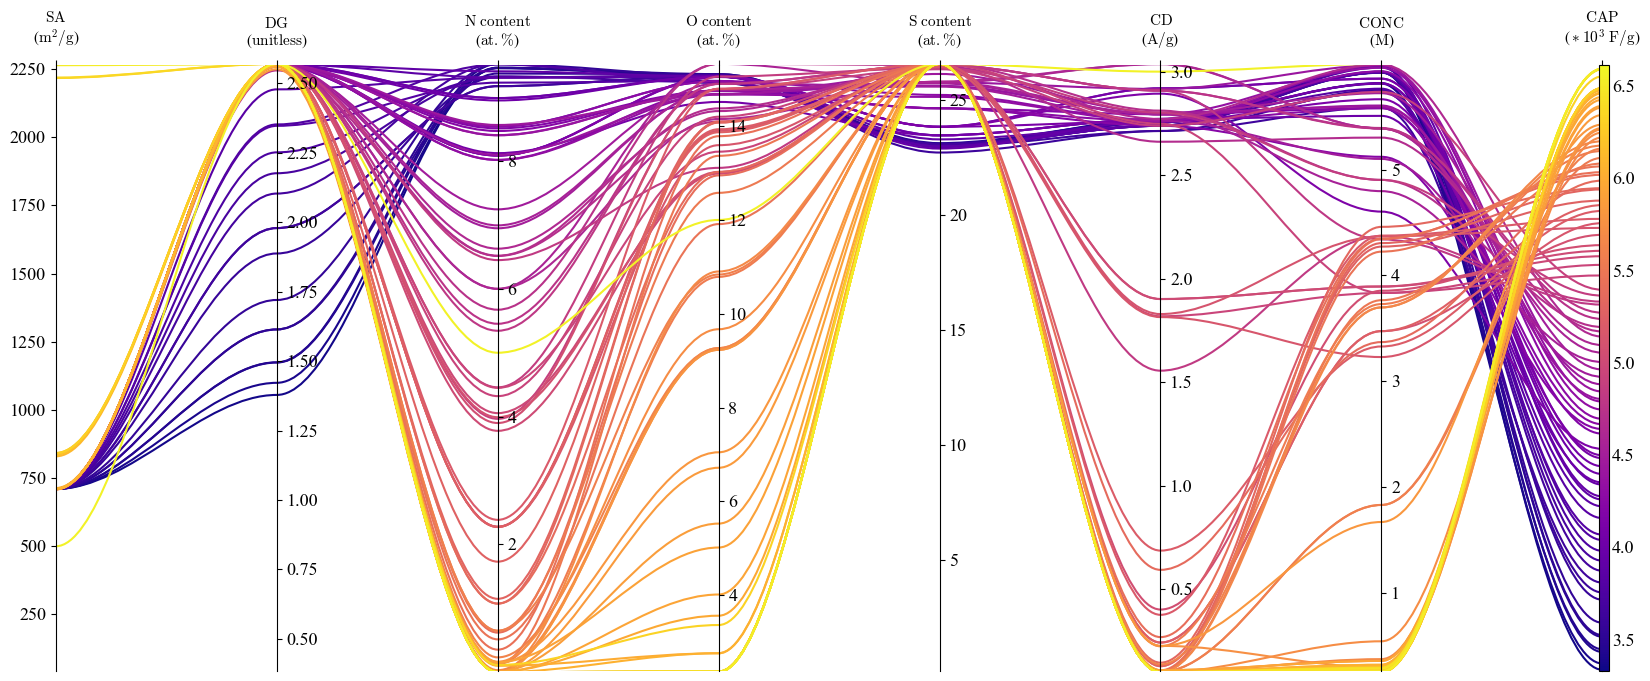

In [30]:
plot_multi_ga_case_D2(result)

The function you have called (subplots_adjust) is not officially supported by Paxplot, but it may still work. Report issues to https://github.com/kravitsjacob/paxplot/issues


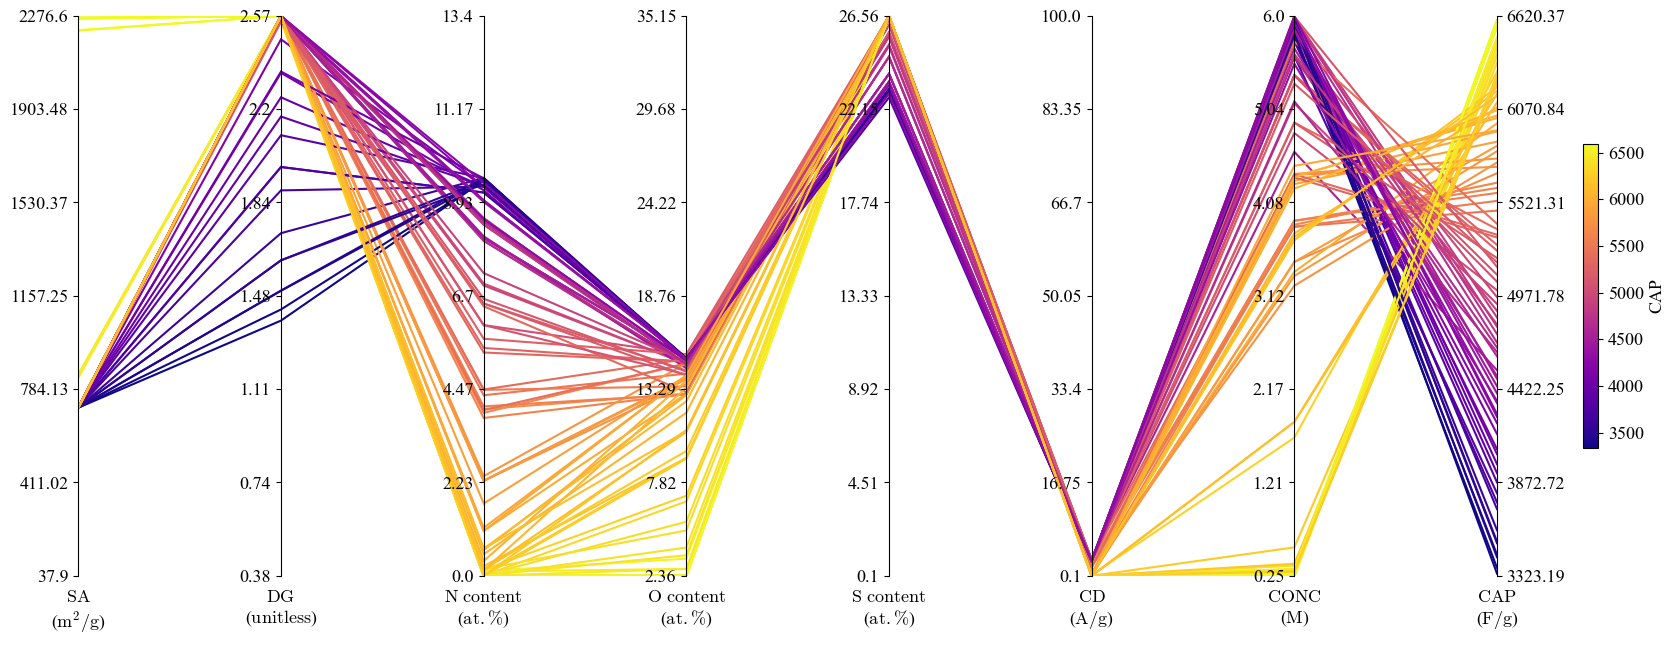

In [25]:
import paxplot as px

dd = pd.DataFrame(result.X, columns=training_data.columns)
dd['CAP'] = -result.F[:, 0]

cols = dd.columns

# Create figure
paxfig = px.pax_parallel(n_axes=len(cols))
paxfig.plot(dd.to_numpy())

# Add labels
paxfig.set_labels(cols)

# Add colorbar
color_col = len(cols) - 1
paxfig.add_colorbar(ax_idx=color_col, cmap='plasma', colorbar_kwargs={'label': cols[color_col]})

# Set limits for each axis
lower_limit = {
                'SA':  37.90, 'DG': 0.38, '%N': 0.00, '%O': 2.36,
                '%S': 0.10, 'CD': 0.10, 'CONC': 0.25, 'CAP': min(dd['CAP']) - min(dd['CAP'])*0.004
                }

upper_limit = {
                'SA':  2276.60, 'DG': 2.57, '%N': 13.40, '%O': 35.15,
                '%S': 26.56, 'CD': 100.00, 'CONC': 6.00, 'CAP': max(dd['CAP']) + max(dd['CAP'])*0.004}

for idx, col in enumerate(cols):
    paxfig.set_lim(ax_idx=idx, bottom=lower_limit[col], top=upper_limit[col]) 

# set figure size
paxfig.set_size_inches(19, 8)
paxfig.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9)  # Padding


# set labels
all_labels = [
            r'$\rm SA$', r'$\rm DG$', r'$\rm N\ content$', r'$\rm O\ content$',
            r'$\rm S\ content$', r'$\rm CD$', r'$\rm CONC$', r'$\rm CAP$']

all_units = [
                    r'$\rm m^{2}/g$', r'$\rm unitless$', r'$\rm at.\%$', r'$\rm at.\%$',
                    r'$\rm at.\%$', r'$\rm A/g$', r'$\rm M$', r'$\rm F/g$']
        

labels = [f'{all_labels[i]}\n({all_units[i]})' for i in range(len(all_labels))]
paxfig.set_labels(labels)

plt.show()
